In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
import plotly.express as px

## Import New York Times's dataset, parse date parameter makes sure the dates are in the proper format, it also helps us to work on this dataset as time series.
The advantage of importing a dataset directly from a URL is that you'll always get an up to date infromation on COVID-19

In [6]:
covid_df=pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/us-states.csv', parse_dates=True)

In [7]:
#Checking that the dataset is imported correctly and looks good
covid_df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [8]:
#Dropping the 'fips' column as it is meant for geolocation info, which I'm not using in my analysis (so far)
covid_df.drop('fips', axis=1, inplace=True)

## This code uses the groupby and sort functions to plot infections and deaths in each state by descending order. We clearly see that New York and New Jersey dwarf other states.

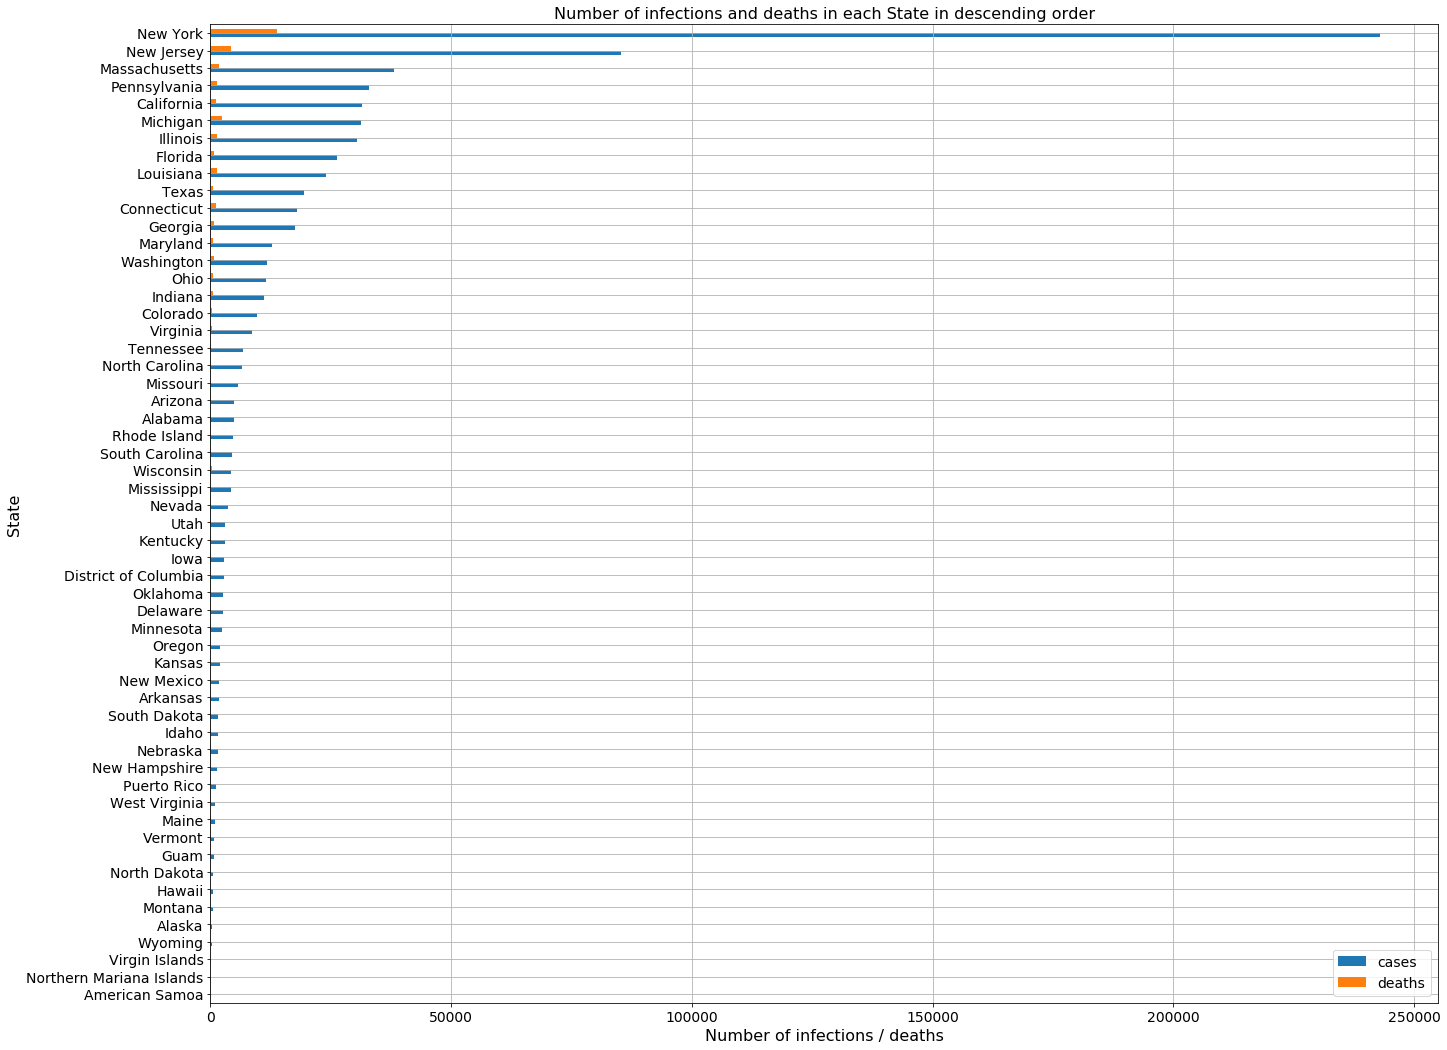

In [9]:

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=True).plot\
(kind='barh', figsize=(22,18), grid=True, fontsize=14)
plt.ylabel('State', fontsize=16)
plt.xlabel('Number of infections / deaths', fontsize=16)
plt.title('Number of infections and deaths in each State in descending order', fontsize=16)
plt.legend(loc='lower right', fontsize=14)
plt.show()

In [10]:
#covid_df[['date','state','cases','deaths']].groupby('state').sum().plot(kind='bar', figsize=(25,15))

In [11]:
#ax1=plt.gca()
#covid_df[covid_df['state']=='New York'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax1, label='New York', grid=True)
#covid_df[covid_df['state']=='New Jersey'][['state','cases', 'date']].loc[:].plot(x='date', figsize=(25,15), dashes=[2,2], alpha=0.8, ax=ax1, label='New Jersey', grid=True)
#ax1.legend()
#plt.show()
#covid_df[covid_df['state']=='Washington'].loc[800:].plot(x='date', figsize=(25,15), kind='line', alpha=0.5, ax=ax1)

## Creating a new dataframe with New York data for separate analysis

In [12]:
NY_df=covid_df[covid_df['state']=='New York'][['state','cases', 'deaths', 'date']]

In [13]:
#Copying the date column to the index and dropping the date column which reduces the size of our dataframe and makes it easier to read
NY_df.index=NY_df.date
NY_df.drop(columns='date', inplace=True)
NY_df.head()

,state,cases,deaths
date,,,
2020-03-01,New York,1,0
2020-03-02,New York,1,0
2020-03-03,New York,2,0
2020-03-04,New York,11,0
2020-03-05,New York,22,0


In [14]:
#NY_df.cases.astype('int32', copy=False)

In [15]:
#NY_df.index.astype('datetime64[ns]')

## Plotting cumulative cases in New York State

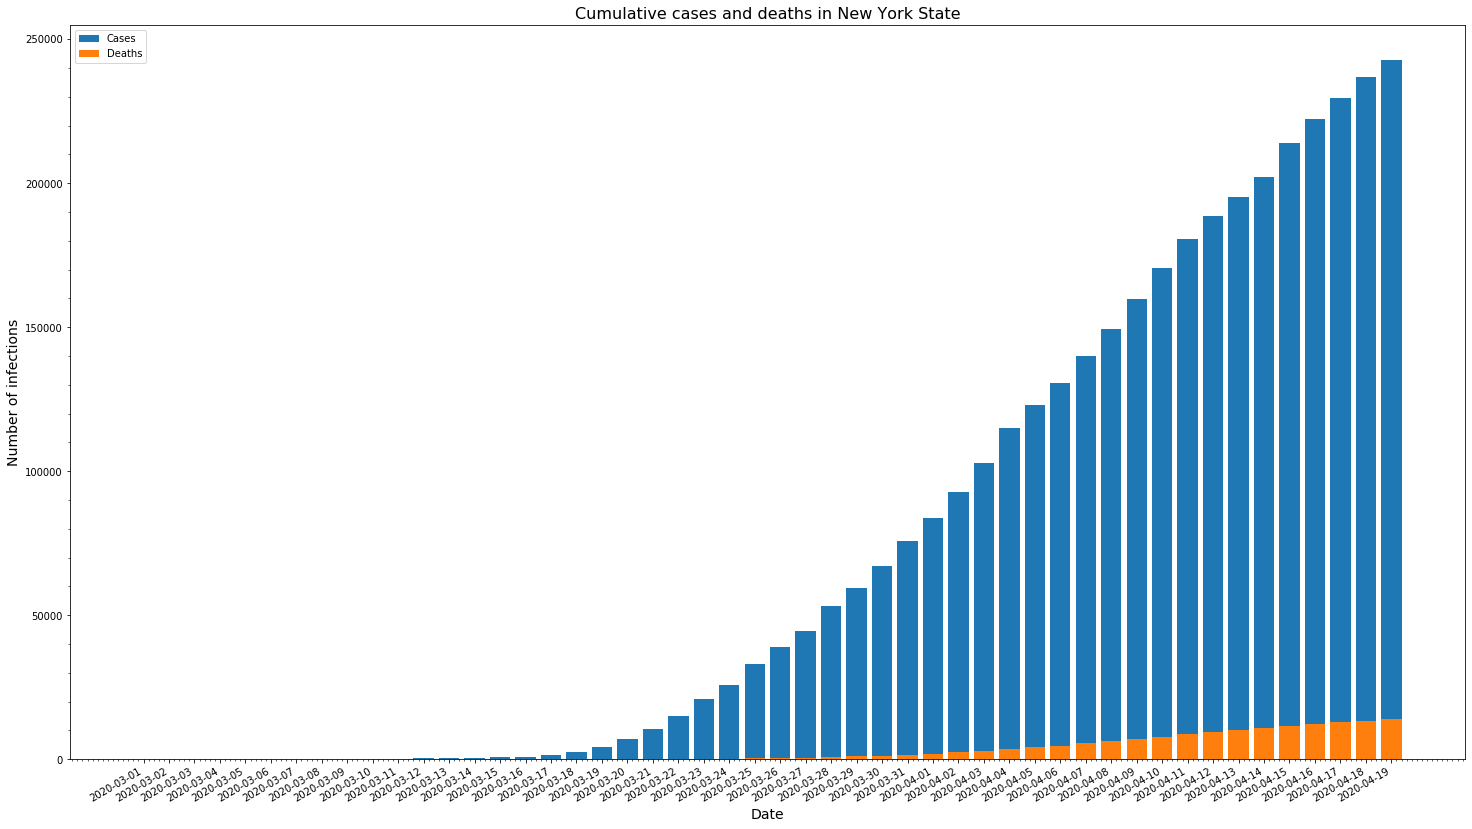

In [16]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.cases, label='Cases')
ax.bar(NY_df.index, NY_df.deaths, label='Deaths')
plt.legend()
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of infections', fontsize=14)
plt.title('Cumulative cases and deaths in New York State', fontsize=16)
plt.minorticks_on()
plt.show()

## Since daily fluctuations in number of infections and deaths could confuse analysis, we use below a statistical method of rolling or moving averages to calculate short and long averages which take into account a 3 and a 7 day rolling averages. We will plot the results separately and we can observe that the longer the rolling window, the smoother are the lines that reflect daily cases.

In [17]:

NY_rollshort=NY_df.cases.rolling(window=3)
NY_rolllong=NY_df.cases.rolling(window=7)
NY_df['SMA_short']=NY_rollshort.mean()
NY_df['SMA_long']=NY_rolllong.mean()
NY_df['New_cases']=0
NY_df['New_cases_Short_MA']=0
NY_df['New_cases_Long_MA']=0
NY_df['New_deaths']=0
NY_df.fillna(0, inplace=True)



In [18]:
#Veryfying the dataset lenght
#len(NY_df)
#NY_df.loc[:,('cases')][2]

## The below code 'For loop' is done to calculate daily new cases of infections and deaths since the data set provides cumulative daily case. Hence a simple for loop is done to calculate the difference in infections between a day and the preceding day for infections and deaths. The same is done for the 3 and 7 day averages.

In [19]:
for i in range(len(NY_df)):
    if NY_df.cases[i]==1:
        i+=1
    else:
        NY_df.New_cases[i]=NY_df.cases[i]-NY_df.cases[i-1]
        NY_df.New_deaths[i]=NY_df.deaths[i]-NY_df.deaths[i-1]
        NY_df.New_cases_Short_MA[i]=NY_df.SMA_short[i]-NY_df.SMA_short[i-1]
        NY_df.New_cases_Long_MA[i]=NY_df.SMA_long[i]-NY_df.SMA_long[i-1]

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\amg_m\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A valu

## We plot the daily new cases of infections and deaths in New York State using matplotlib. The three charts below are self-explanatory

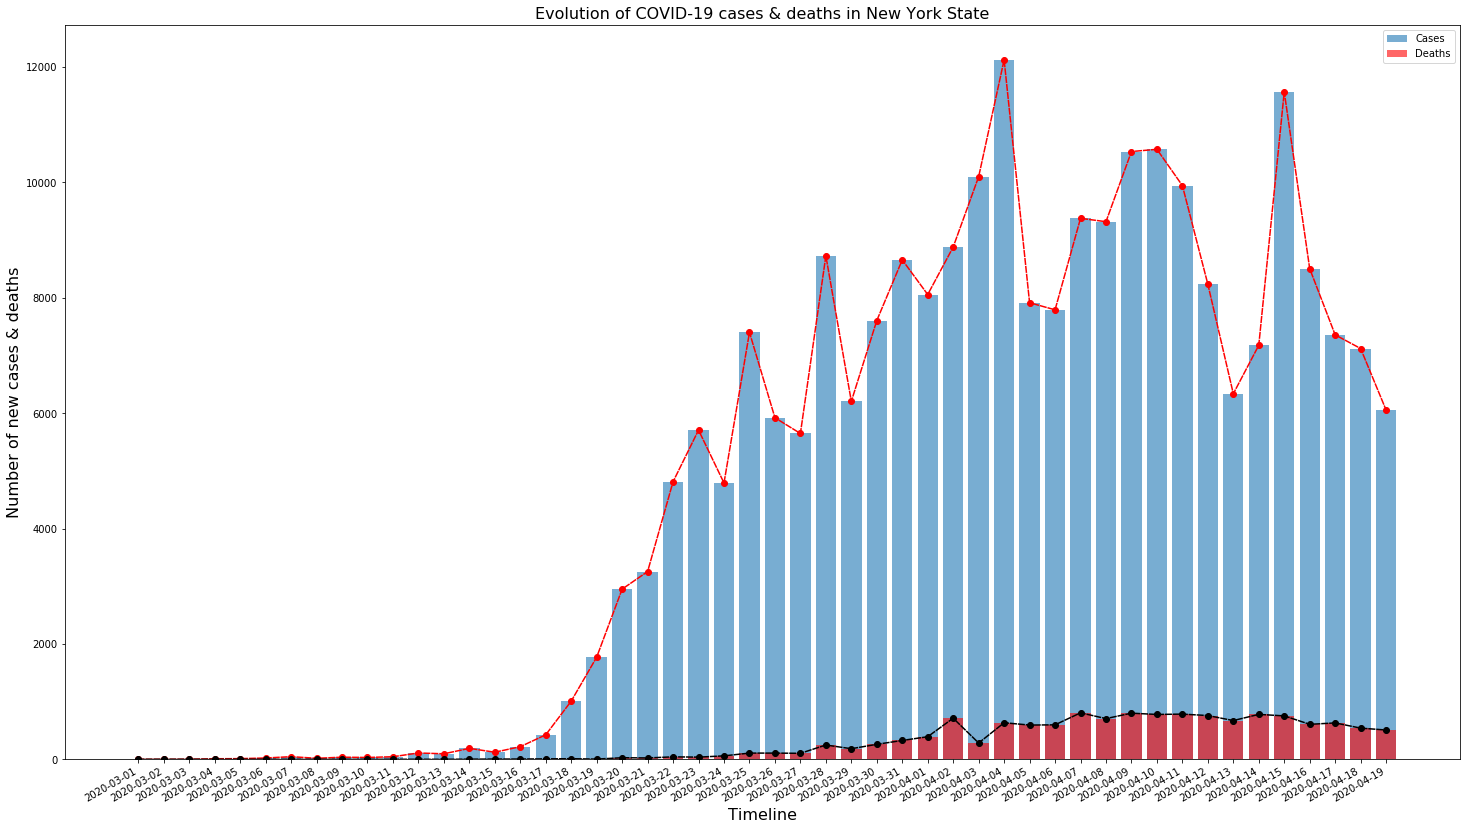

In [20]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.New_cases, alpha=0.6, label='Cases')
ax.bar(NY_df.index, NY_df.New_deaths, alpha=0.6, color='red', label='Deaths')
ax.plot(NY_df.index, NY_df.New_cases, 'ro--', dash_capstyle='projecting' )
ax.plot(NY_df.index, NY_df.New_deaths, 'ko--', dash_capstyle='projecting' )
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in New York State', fontsize=16)
plt.ion()
plt.savefig('COVID19NYC.pdf', bbox_inches='tight')
plt.show()

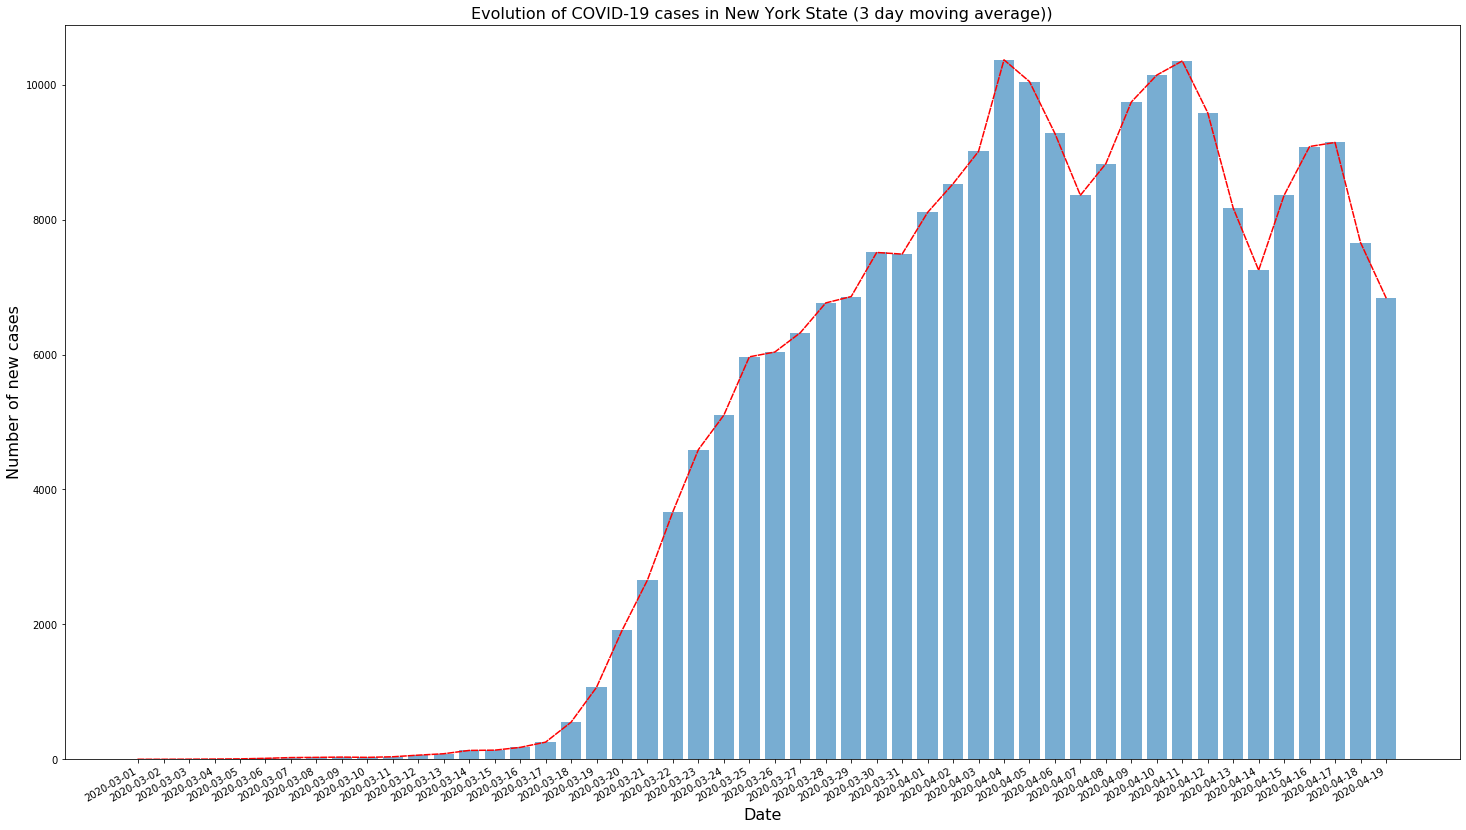

In [21]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.New_cases_Short_MA, alpha=0.6)
ax.plot(NY_df.index, NY_df.New_cases_Short_MA, 'r--', dash_capstyle='projecting' )
fig.autofmt_xdate()
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of new cases', fontsize=16)
plt.title('Evolution of COVID-19 cases in New York State (3 day moving average))', fontsize=16)
plt.show()

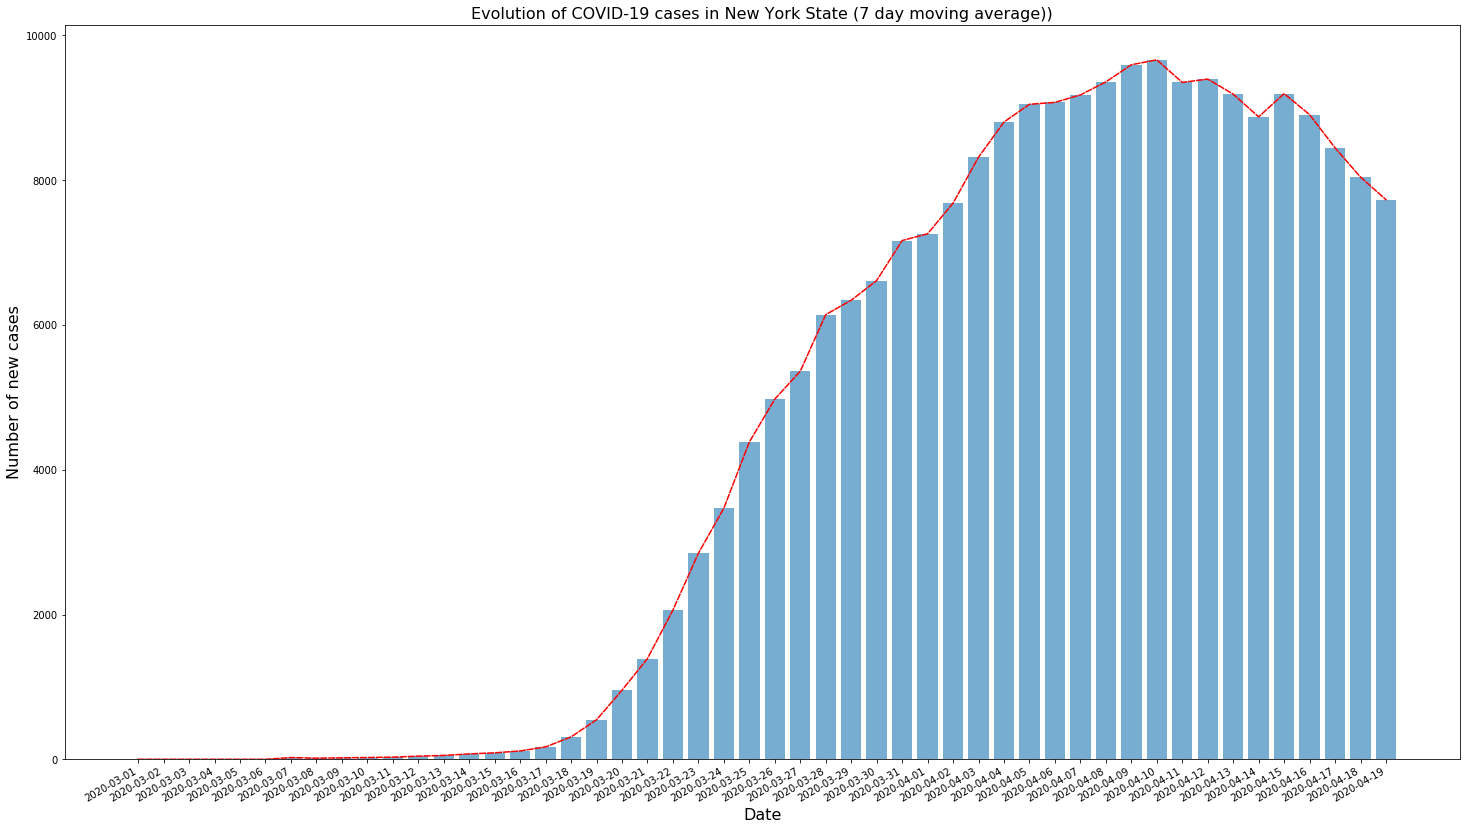

In [22]:
fig, ax=plt.subplots(figsize=(25,15))
ax.bar(NY_df.index, NY_df.New_cases_Long_MA, alpha=0.6)
ax.plot(NY_df.index, NY_df.New_cases_Long_MA, 'r--', dash_capstyle='projecting' )
fig.autofmt_xdate(which='major')
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of new cases', fontsize=16)
plt.title('Evolution of COVID-19 cases in New York State (7 day moving average))', fontsize=16)
plt.show()

## The below chart reflects the same trend but with a dashed line using the same library

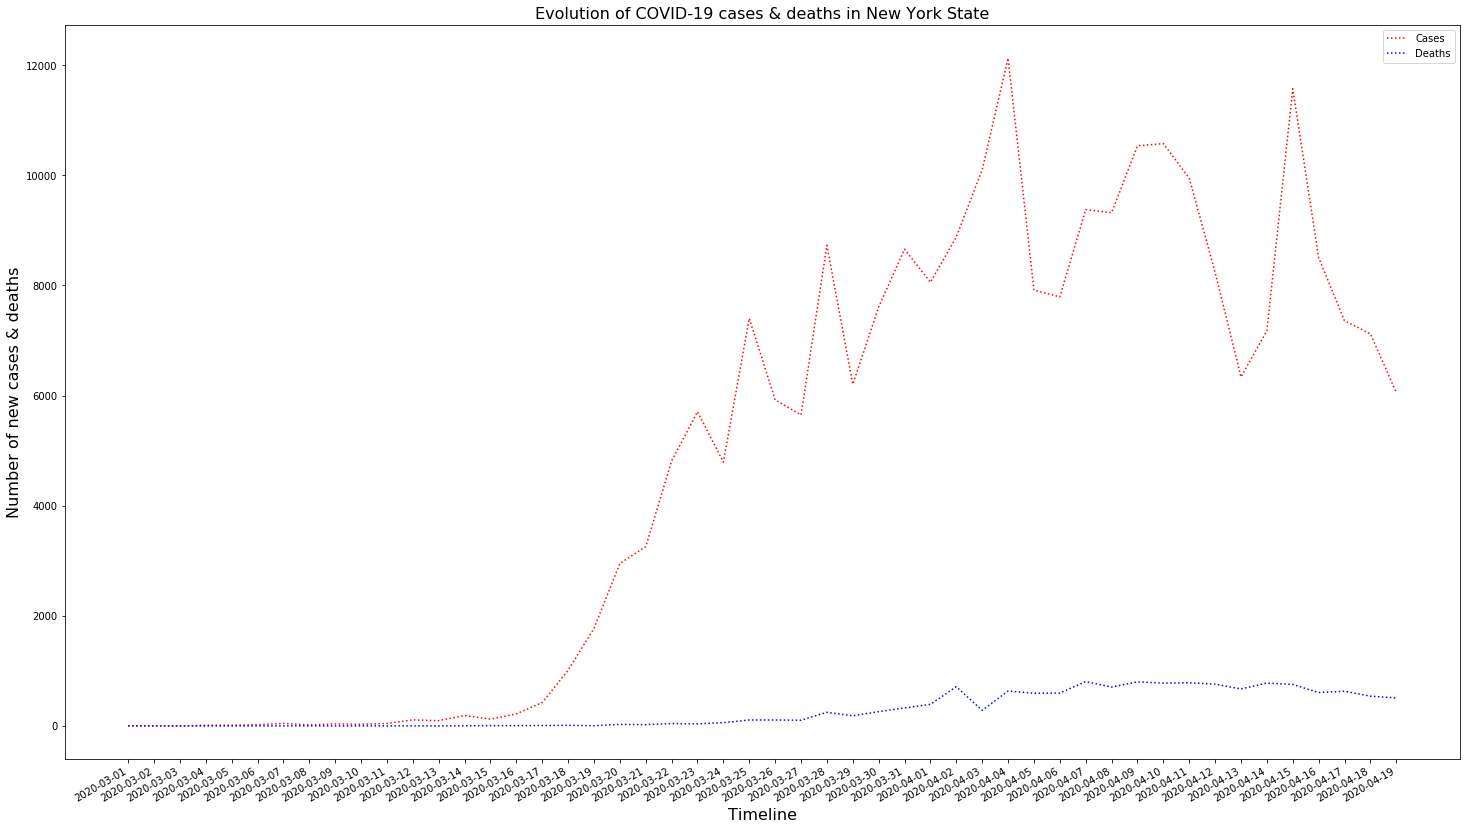

In [23]:
fig, ax=plt.subplots(figsize=(25,15))
ax.plot(NY_df.index, NY_df.New_cases, 'r:', label='Cases')
ax.plot(NY_df.index, NY_df.New_deaths, 'b:', label='Deaths')
fig.autofmt_xdate()
plt.xlabel('Timeline', fontsize=16)
plt.ylabel('Number of new cases & deaths', fontsize=16)
plt.legend()
plt.title('Evolution of COVID-19 cases & deaths in New York State', fontsize=16)
plt.show()

In [30]:
fig = px.line(data_frame=NY_df, x=NY_df.index, y='New_cases', title='New COVID-19 case in New York')
fig.show()

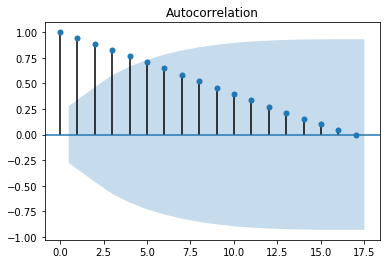

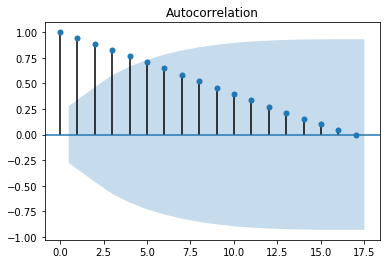

In [21]:
plot_acf(NY_df.cases)

In [169]:
#Total cases & deaths by State sorted descending

covid_df[['state','cases','deaths']].groupby('state').last().sort_values('cases',ascending=False)

,cases,deaths
state,,
New York,236763,13362
New Jersey,81420,4070
Massachusetts,36372,1560
Pennsylvania,31742,1150
California,30829,1146
Michigan,30717,2307
Illinois,29160,1272
Florida,25484,747
Louisiana,23580,1267


In [170]:
choroplet_df=covid_df[['state','cases','deaths']].groupby(by='state', as_index=True).last()
#choroplet_df['State']=choroplet_df['state']


In [171]:
#Total cases in the US

covid_df[['state','cases','deaths']].groupby('state').last().sum()

cases     728094
deaths     34726
dtype: int64

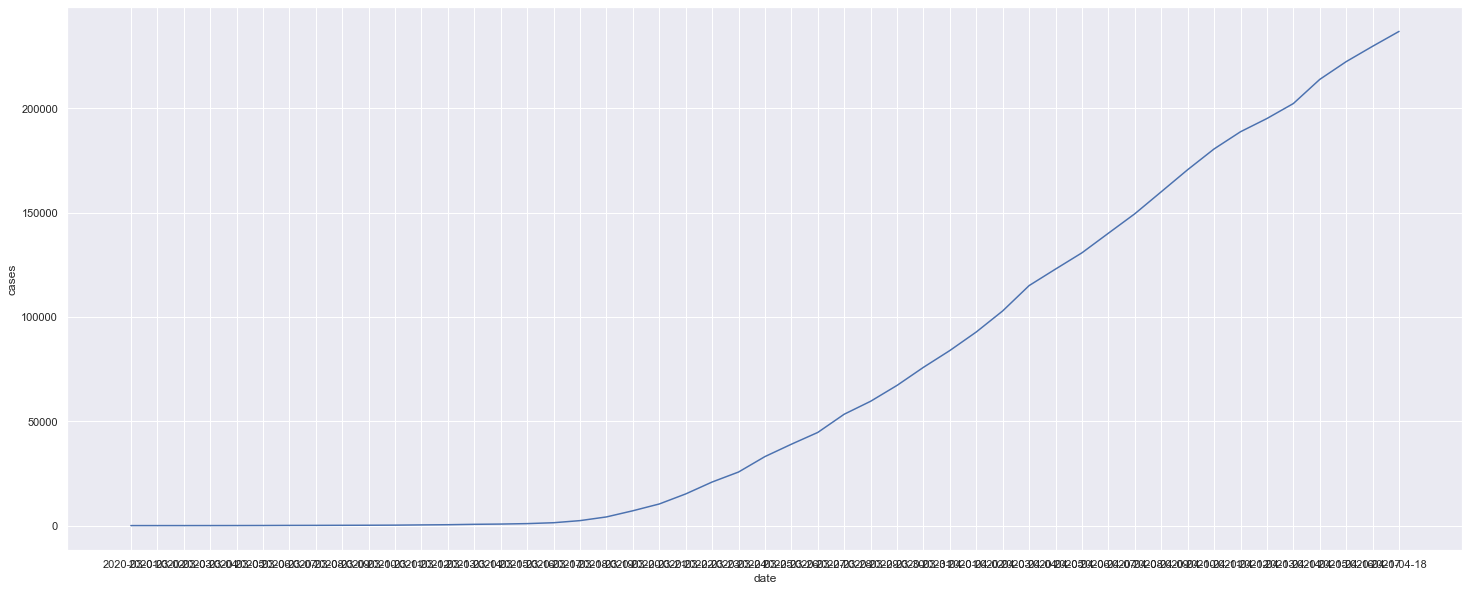

In [172]:
sns.set(rc={'figure.figsize':(25,10)})
sns.lineplot(data=covid_df[covid_df['state']=='New York'], x='date',y='cases')


In [173]:
m = folium.Map(location=[45.5236, -122.6750])

In [254]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'
#state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
#state_data = pd.read_csv(state_unemployment)

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=choroplet_df,
    columns=[choroplet_df.index, 'cases'],
    key_on='feature.properties.name',
    bins=[0,100,1000,5000, 20000, 50000, 100000, 250000],
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of COVID-19 cases'
    
).add_to(m)

folium.LayerControl().add_to(m)

m